# Practical Machine Learning: How To Find Best Parameters In An Icequake Simulation Model With Simulated Annealing And MCMC Algorithm

**Claire Coutelle,
M2 SCAHC, Université Grenoble Alpes,
November 2022**



*Based on the Practical Machine Learning MCMC Project by L. Moreau, modified.*

***

## Context

In this project, we are going to apply the Markov Chain Monte Carlo algorithm to a set of seismic data recorded on sea ice. These data were recorded with 5 geophones installed on sea ice, as shown in the following figure. The geophones are marked with black squares numbered $S_1$ to $S_5$:

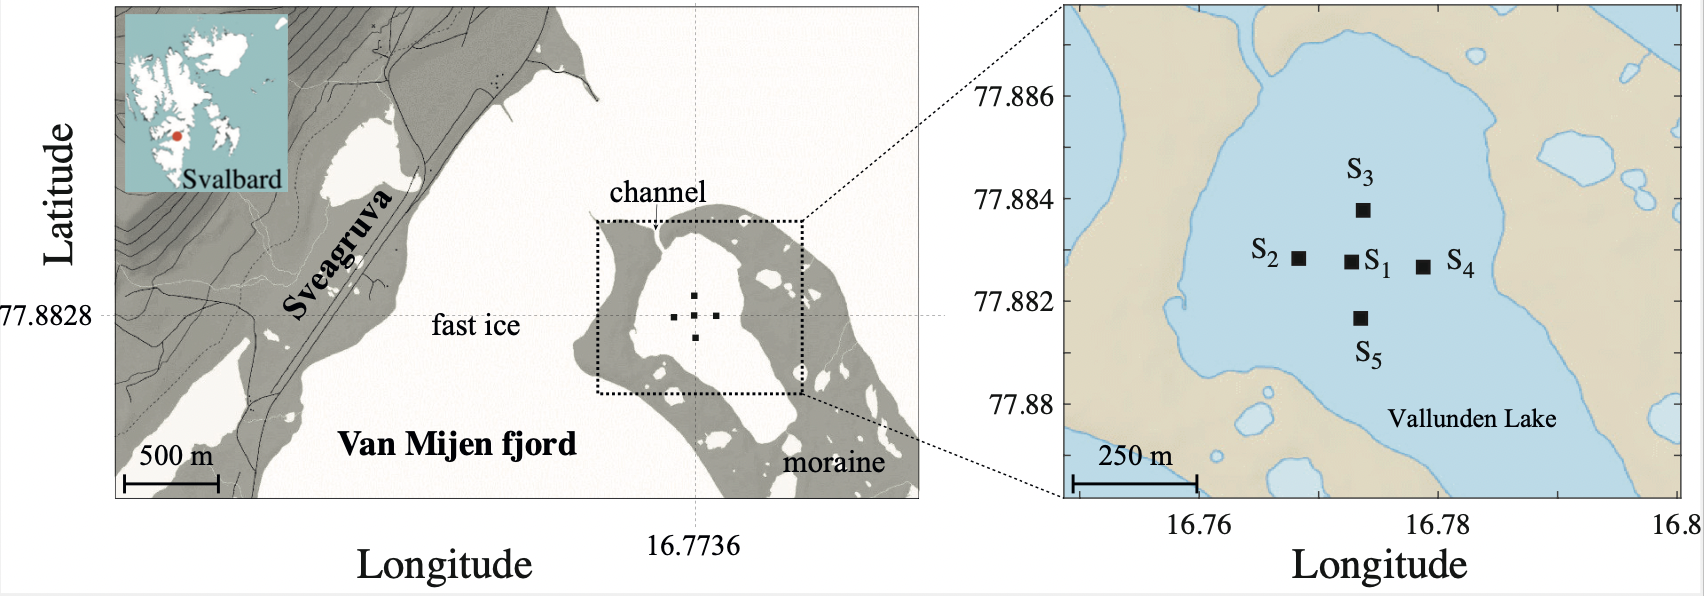





Each geophone recorded seismic noise for about one month. We used a deep learning approach (see Seydoux et al. *Clustering earthquake signals and background noises in continuous seismic data with unsupervised deep learning*, Nature Communication) for clustering the various parts of the signal into specific families:
- icequakes
- noise
- human activities etc
The icequakes have been extracted, and then saved in the *iqks_IWG_125505_cluster00_with_dates.hdf5* file. To analyse these data, we need to load the following modules. 

The goal is to analyze icequakes recordings to estimate the Probability Density Function (PDF) of the following parameters:
- the icequakes longitude and latitude
- an average sea ice thickness
- the time of emission of icequake

## Measured data

Let us import useful packages to display real data of surveyed icequakes. **PLEASE import your working path below.**

In [1]:
import numpy as np
from random import random
import os , sys
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import pickle
import shutil
from matplotlib.ticker import FormatStrFormatter

MODULE_FULL_PATH = #ENTER YOUR WORKING PATH 
sys.path.insert(1, MODULE_FULL_PATH)
import mcmc_iqk





- The **numpy** library, for array calculation and basi signal processing. 
- the **random**, for generating random numbers needed for MCMC methods. 
- the **os** and **sys** modules, for basic exploration of teh system and creation of folders
- the **matplotlib**, for generating/saving figures 
- the **pickle**, for saving Python files 
- the **shutil**, for files and paths manipulation
- the **mcmc_iqk**,for reading the data, plotting and saving the inversion, and forward modeling. 
- the **FormatStrFormatter** to better display tick-labels on axis.

The GPS coordonates of the geophones are listed below. The number of each station (0 to 4) is given as the first entry to the **stations** array. For each station, there is a ID number (125505, 501101, 201104, 301103, or 401103), a latitude and a longitude. 

In [2]:
sta_cluster = 125505
stations = np.zeros((5,3)) 
stations[0,0] = 125505
stations[0,1] = 77.882769440000004
stations[0,2] = 16.772766669999999
stations[1,0] = 501101
stations[1,1] = 77.883772219999997
stations[1,2] = 16.773727780000002
stations[2,0] = 201104
stations[2,1] = 77.882833329999997
stations[2,2] = 16.768333330000001
stations[3,0] = 301103
stations[3,1] = 77.881669439999996
stations[3,2] = 16.773522220000000
stations[4,0] = 401103
stations[4,1] = 77.882663890000003
stations[4,2] = 16.778752780000001
Nsta = stations.shape[0]



Next, we give the script some information about where to look for the data, where to save things etc. 

What is important here is the parameter denoted by **iqk**. This should be an integer. This will tell the script which icequake will be analyzed with the MCMC algorithm. 

In [4]:
cluster = 0
iqk = 0
path2icqks = MODULE_FULL_PATH
method = 'stft'
path2save = path2icqks + 'output_'+method + '_cluster'+  f'{cluster:02d}'+'_' +f'{iqk:05d}'+ '/'
name2saveMCMC = 'inv_family_' + f'{cluster:02d}' +'_MCMC.hdf5' 
name2saveSA = 'inv_family_' + f'{cluster:02d}' +'_SA.hdf5' 
if os.path.exists(path2save):
    shutil.rmtree(path2save)
os.makedirs(path2save)


Next, we load the data, using script *read_data* of the mcmc_iqk module. Signals are sampled with a sampling frequency of 250 Hz, and then band-passed filtered between $f_{min}=1$ Hz and $f_{max}=70$ Hz. Use plot=1 to show the data, and plot=0 otherwise. **The parameter *res* enables to chose the resolution of the data in order (if need be), to run the algorithms faster.**

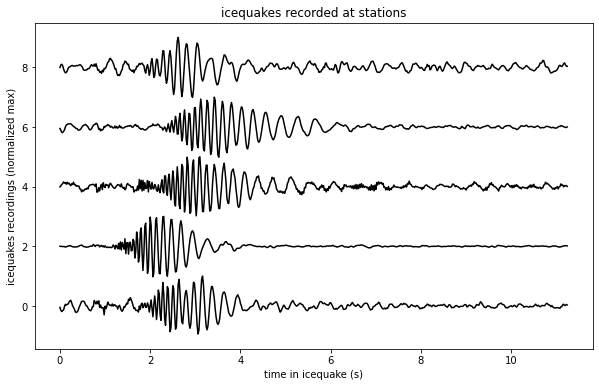

In [306]:
# read the data, extract spectrum and center frequency
res = 5
fmin = 1 / res
fmax = 70 / res
fe = 250 / res
data, data_spect, fc,iqk_time = mcmc_iqk.read_data.read_data(path2icqks,stations,sta_cluster,cluster,iqk,fmin,fmax,fe,res,plot=1)


Nt = len(data[0]); 
t = np.arange(0,Nt/fe,1/fe) 
if len(t) > Nt:
    t = t[0:-1]


To compare the field data with synthetic data from the forward model, it can be judicious to choose a different representation than the above time-domain signals. 

For several reasons that can be found in the scientific paper in attached file named **2020_Moreau_JGRO_2.pdf**, instead of time-domain signals we use a frequency vs time representation of the signal. We are just going to say that this makes the cost function between field data and synthetic data more convex.

In this representation, the focus is made on the temporal variations of the frequency content. The simplest way to achieve this is with a Short-Time Fourier Transform (STFT) analysis. This function splits each signal into sine and cosine functions. The scalograms below represent the amplitude of each sine and cosine function against time.


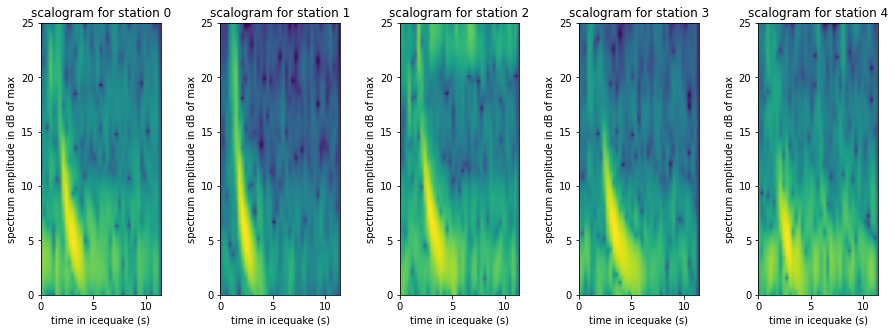

In [279]:
# perform time-frequency analysis of the data with method defined above
data_scalogram = mcmc_iqk.data_cwt.data_cwt(data,fe,method,plot=1)

With this representation, the spectrum indicates that high frequencies arrive first, and low frequencies arrive later. This phenomenon is called dispersion. It occurs when the speed of the wave varies with frequency. 

## Simulated Annealing Algorithm: How To Define A Parameters Research Area 

Now we can start implementing the Simulated Annealing and MCMC algorithm, starting with the search space. In the following, we consider for the prior distribution that the model parameters have equal
probability over a finite range of values defined below:

In [280]:
# SEARCH SPACE BOUNDARIES

lon_max = 16.8
lon_min = 16.74 
lat_max = 77.8875
lat_min = 77.875
max_thickness = 1
min_thickness = 0.2

Next we setup the forward model by creating a library of synthetic data, on the basis of the following mechanical properties of sea ice:  

In [281]:
# SEA ICE PARAMETERS TO USE AS INPUT FOR MODEL

rho_ice = 910     # density of sea ice
E = 3.8e9         # Young's modulus of sea ice
nu = 0.321        # Poisson's ratio of sea ice
c_w = 1410;       # speed of sound in cold water
rho_w = 1010;     # density of cold water

A reference signal of same size as the signals in the field data is generated. This signal will be used as input to the forward model. The forward model will propagate this signal in sea ice, given the above mechanical parameters, and those for which we want to estimate the PDF:

In [282]:
# SIGNAL TO USE AS INPUT FOR FORWARD MODEL
t0 = 0.5
SNR = np.inf
pulse = []
#fig1, axs1 = plt.subplots(1,1, figsize=(15, 5), facecolor='w', edgecolor='k')
for ista in range(len(stations)): 
    ncycle = 1.5/fc[ista]
    pulse.append(mcmc_iqk.gaussian_toneburst.gaussian_toneburst(fc[ista],t,t0,ncycle,0,0,SNR) )
    pulse_spect = np.fft.fft(pulse[ista])      
    idx = np.where(pulse_spect == 0)[0]
    if len(idx) != 0:
        for i_idx in idx:
            pulse_spect[i_idx] = pulse_spect[i_idx-1] 
    pulse_spect = pulse_spect/abs(pulse_spect)*abs(data_spect[ista])
    pulse[ista] = np.real(np.fft.ifft(pulse_spect))   

In [283]:
# CHECK IF WAVENUMBERS LIBRARY FOR MODEL ALREADY EXISTS - IF NOT, CREATES IT
if os.path.exists(path2icqks+'wavenum_cph_cluster'+  f'{cluster:02d}'+ '/'+'wavenum_and_cph_iqk'+str(iqk)+'.pkl'):
    with open(path2icqks+'wavenum_cph_cluster'+  f'{cluster:02d}'+ '/'+'wavenum_and_cph_iqk'+str(iqk)+'.pkl','rb') as f:  # Python 3: open(..., 'rb')
        k_QS, cph, hhh = pickle.load(f)
else:   
    dh = 1e-2; hhh = np.arange(min_thickness,max_thickness+dh,dh)
    cph = np.zeros((len(hhh),int((Nt-1)/2+1)))
    k_QS = np.zeros((len(hhh),int((Nt-1)/2+1)))
    for ih in range(len(hhh)):
        freq,k_QS[ih,:],_,_,cph[ih,:] = mcmc_iqk.fwd_model.wavenumbers_stein( rho_ice, hhh[ih], E, nu, fe,t,c_w,rho_w)

    with open(path2icqks+'wavenum_cph_cluster'+  f'{cluster:02d}'+ '/'+'wavenum_and_cph_iqk'+str(iqk)+'.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([k_QS, cph, hhh], f)

Now the forward model can be used in the following way. It yields synthetical data.

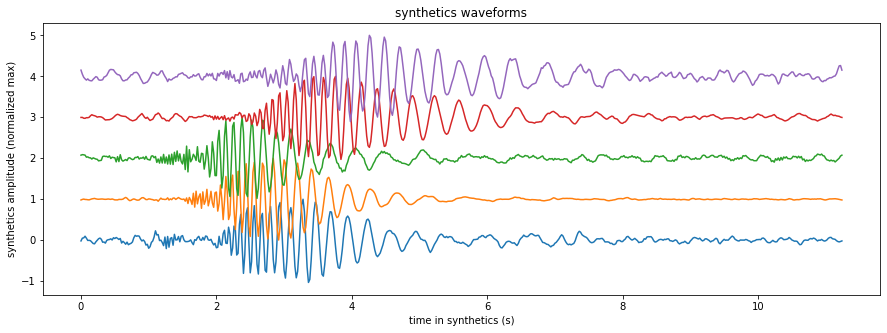

In [284]:
it = 1
delta_param = delta_param0/10
Xcand = mcmc_iqk.candidate.candidate(X[:,it-1],delta_param,MIN_param0,MAX_param0);     
synthetics = mcmc_iqk.synthetics.synthetics(stations,Xcand,t,pulse,cph[np.abs(hhh - Xcand[0]).argmin()],plot=1)    


We can setup our Simulated annealing and MCMC algorithms:

In [420]:
# SIMULATED ANNEALING AND MCMC SCHEDULES

N_SA = 10000              # number of iterations for simulated annealing
N_MCMC = 50000            # number of iterations for MCMC
seuil = 100                 #seuil pour le nombre de candidats refusés
T0 = 0.3 ; Tmin = 0.0003    # temperatures limits for cooling schedule in simulated annealing
T0param = 0.1; Tminparam = 0.008  # temperatures limits for parameters search refining in simulated annealing

The four parameters are stored in a matrix denoted by $X$:
- the first line of $X$ contains the thickness of sea ice in the Markov chain
- the first line of $X$ contains the icequake latitude in the Markov chain
- the first line of $X$ contains the icequake longitude in the Markov chain
- the first line of $X$ contains source activation time in the Markov chain

The search space is bounded between arrays **MAX_param0** and **MIN_param0**

**delta_param0** is the jump size from the current position in X and the candidate, at the beginning of the simulated annealing algorithm. For example:

- setting **delta_param0 = (MAX_param0 - MIN_param0)**, the jump can be in the whole parameter space. 
- setting **delta_param0 = (MAX_param0 - MIN_param0)/10**, the jump can only be as far as 1/10$^\text{th}$ of the whole parameter space.



Finally, we will need some functions for the SA and MCMC loops. The cost function is in the **mcmc_iqk.cost_function** file.

In [286]:
def Likelihood(cost,sigma):
    return np.exp((-cost*cost)/sigma) 
    #return 2**((-cost*cost)/sigma*sigma)

    
#Both following functions are used to probabilities of acceptance

def ProbaOfAcceptance(newlikelihood,prevlikelihood):
    return newlikelihood/prevlikelihood

def AcceptanceTest(s):
    alpha = np.random.uniform(0,1)
    if alpha <= np.min([s,1]):
        return True
    else:
        return False

Now let us initialize the SA algorithm.

In [411]:
# Initialisation for simulated annealing
X = np.zeros((4,N_SA))
X[0,0] = 0.5
X[1,0] = 77.8752
X[2,0] = 16.75
X[3,0] = 0
        
MAX_param0 = np.zeros(4)
MIN_param0 = np.zeros(4)    
MAX_param0[0] = max_thickness
MIN_param0[0] = min_thickness   
MAX_param0[1] = lat_max   # max latitude
MIN_param0[1] = lat_min   # min latitude
MAX_param0[2] = lon_max   # max longitude
MIN_param0[2] = lon_min   # min longitude
MAX_param0[3] = t[-1]     # max lag
MIN_param0[3] = -t[-1]    # min lag

delta_param0 = (MAX_param0 - MIN_param0)

RMS_accepted_SA = np.ones(N_SA)  #save the cost function values

T_values_SA = np.exp(-np.linspace(-np.log(T0),-np.log(Tmin),N_SA))   #describe how the temperature will decrease during SA
#T_values_SA = 2**(-np.linspace(-np.log2(T0),-np.log2(Tmin),N_SA))

Tparam_values = np.exp(-np.linspace(-np.log(T0param),-np.log(Tminparam),N_SA))
#Tparam_values = ((T0param - Tminparam)/N_SA)*np.linspace(0,N_SA,N_SA)

likelihood = np.zeros(N_SA)        #save the probabilities of acceptance

X0_SA = mcmc_iqk.candidate.candidate(X[:,0],delta_param0,MIN_param0,MAX_param0)    #first candidate

synthetics0_SA = mcmc_iqk.synthetics.synthetics(stations,X0_SA,t,pulse,cph[np.abs(hhh - X0_SA[0]).argmin()],plot=0)  #compute synthetical dataset based on first candidate

RMS_accepted_SA[0] = cost_function(data_scalogram,synthetics0_SA)  #cost of first candidate dataset

distance_SA = RMS_accepted_SA[0]

sigma_SA = T0

delta_param = delta_param0

prevlikelihood = Likelihood(distance_SA, T0)

likelihood[0] = prevlikelihood


We are ready to run the code. You can chose to print rank of iteration, cost, probability of acceptance and number of trials before the candidate is accepted by uncommenting the corresponding lines. It will print the results : it_critic, T_critic and rank of lower cost.

In [412]:
#SA LOOP

i=1
it_critic = 0
T_critic = 0
I=0
trials = 1
s_average = 0

while i < N_SA:
    
    if trials >= seuil:
        it_critic = i
        break
        
    else:
        
        DATA_cand = mcmc_iqk.candidate.candidate(X[:,i-1],delta_param,MIN_param0,MAX_param0)
        synthetics = mcmc_iqk.synthetics.synthetics(stations,DATA_cand,t,pulse,cph[np.abs(hhh - DATA_cand[0]).argmin()],plot=0)
        newdistance = mcmc_iqk.cost_function.cost_function(data_scalogram,synthetics,fe,method)
        newlikelihood = Likelihood(newdistance, sigma_SA)
        s = ProbaOfAcceptance(newlikelihood,prevlikelihood)
        test = AcceptanceTest(s)
        s_average = s_average + s
        
        if test == False:
            trials = trials + 1
            
        else :
            it_critic = i
            RMS_accepted_SA[i-1] = newdistance
            X[0,i] = DATA_cand[0]
            X[1,i] = DATA_cand[1]
            X[2,i] = DATA_cand[2]
            X[3,i] = DATA_cand[3]
            prevlikelihood = newlikelihood
            likelihood[i] = prevlikelihood
            sigma_SA = T_values_SA[i]
            delta_param = delta_param0*Tparam_values[i]
            i = i + 1
            #print('Iteration number '+str(i-1))
            #print('Candidate accepted after '+str(trials)+' trials')
            #print('Proba of acceptance:'+str(s_average/trials))
            #print('Cost: '+str(newdistance))
            trials=1
            s_average = 0
            
        
I = np.argmin(RMS_accepted_SA)
T_critic = T_values_SA[it_critic-1]

print("The SA loop stoped after "+str(it_critic-1)+" accepted candidates, with T_critic = "+str(T_critic),
      ", and the cost function reaches its global minimum at the index "+str(I))

The SA loop stoped after 98 accepted candidates, with T_critic = 0.00032168016660309723 , and the cost function reaches its global minimum at the index 36


### Convergence of the parameters during simulated annealing

Here we plot the cost vs iterations and the values of the parameters vs iterations. If the temperature and search area parameters are well tuned, we expect a convergence of cost and of the parameters.

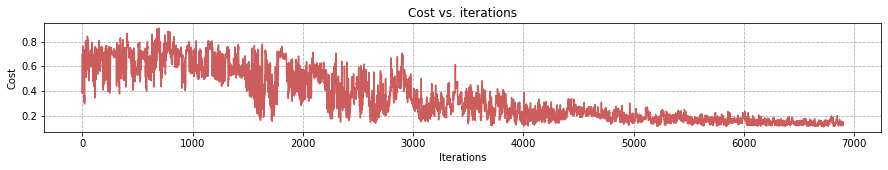

In [406]:
#CONVERGENCE OF COST DURING SA

fig,axs = plt.subplots(figsize = (15,2))
axs.plot(RMS_accepted_SA[:it_critic-1], color='indianred')
axs.set(xlabel = 'Iterations', ylabel = 'Cost')
axs.set_title('Cost vs. iterations')
axs.grid(linestyle='--')

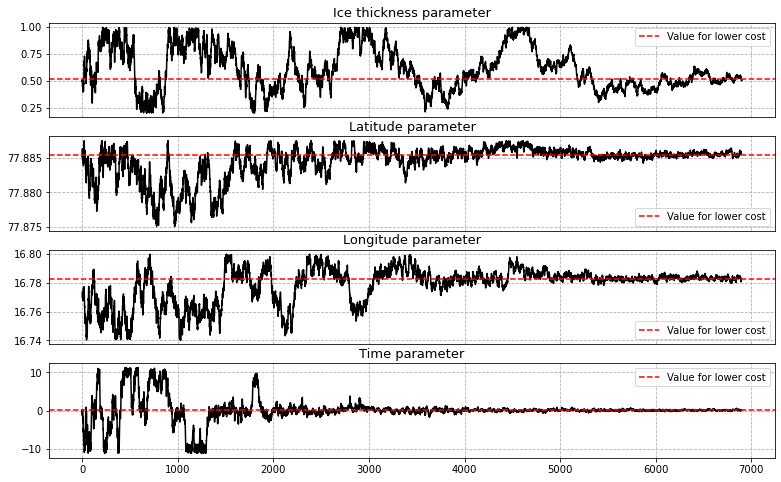

In [291]:
#CONVERGENCE OF PARAMETERS DURING SA

fig,axs = plt.subplots(4,1, sharex = True, figsize = (13,8))
axs[0].plot(X[0,:it_critic-1], color='black')
axs[0].axhline(y=X[0,I],color="red", linestyle = 'dashed', label = 'Value for lower cost')
axs[0].legend()
axs[0].set_title('Ice thickness parameter', size=13)
axs[0].tick_params(axis='x',bottom=False)
axs[0].grid(linestyle='--')

axs[1].plot(X[1,4:it_critic-1], color='black')
axs[1].axhline(y=X[1,I],color="red", linestyle = 'dashed', label = 'Value for lower cost')
axs[1].set_title('Latitude parameter', size=13)
axs[1].legend()
axs[1].tick_params(axis='x',bottom=False)
axs[1].grid(linestyle='--')

axs[2].plot(X[2,3:it_critic-1], color='black')
axs[2].axhline(y=X[2,I],color="red", linestyle = 'dashed', label = 'Value for lower cost')
axs[2].set_title('Longitude parameter', size=13)
axs[2].tick_params(axis='x',bottom=False)
axs[2].grid(linestyle='--')
axs[2].legend()

axs[3].plot(X[3,:it_critic-1], color='black')
axs[3].axhline(y=X[3,I],color="red", linestyle = 'dashed', label = 'Value for lower cost')
axs[3].set_title('Time parameter', size=13)
axs[3].grid(linestyle='--')
axs[3].legend()

At the end of the Simulated annealing phase, we take the temperature at the global minimum to define the variance of the likelihood function in MCMC algorithm :

In [292]:
variance = (T_values_SA[it_critic-1]*1.5)

The best solution found by the Simulated Annealing will be used as the starting position of the MCMC. Hence we store it:

In [293]:
Xbest = X[:,it_critic-1]

## MCMC Algorithm: How to Find Best Values of Parameters 

Now we can initialize the MCMC algorithm:

In [414]:
#Initialisation of MCMC loop

MAX_param0 = np.zeros(4)
MIN_param0 = np.zeros(4)    
MAX_param0[0] = max_thickness
MIN_param0[0] = min_thickness   
MAX_param0[1] = lat_max   # max latitude
MIN_param0[1] = lat_min   # min latitude
MAX_param0[2] = lon_max   # max longitude
MIN_param0[2] = lon_min   # min longitude
MAX_param0[3] = t[-1]        # max lag
MIN_param0[3] = -t[-1]      # min lag   

delta_param0 = (MAX_param0 - MIN_param0)/190

X_MCMC = np.zeros((4,N_MCMC))
X_MCMC[:,0] = Xbest

RMS_accepted = np.ones(N_MCMC)

likelihood = np.zeros(N_MCMC)

X0_MCMC = mcmc_iqk.candidate.candidate(X_MCMC[:,0],delta_param0,MIN_param0,MAX_param0) 

synthetics0 = mcmc_iqk.synthetics.synthetics(stations,X0_MCMC,t,pulse,cph[np.abs(hhh - X0_MCMC[0]).argmin()],plot=0)

RMS_accepted[0] = cost_function(data_scalogram,synthetics0)

distance = RMS_accepted[0]

prevlikelihood = Likelihood(distance, variance)

likelihood[0] = prevlikelihood


Let us run the code.

In [415]:
# MCMC Loop

i=1
trials = 1
s = 0

while i < N_MCMC:
        
    DATA_cand = mcmc_iqk.candidate.candidate(X_MCMC[:,i-1],delta_param0,MIN_param0,MAX_param0)
    synthetics = mcmc_iqk.synthetics.synthetics(stations,DATA_cand,t,pulse,cph[np.abs(hhh - DATA_cand[0]).argmin()],plot=0)
    newdistance = mcmc_iqk.cost_function.cost_function(data_scalogram,synthetics,fe,method)
    newlikelihood = Likelihood(newdistance, variance)
    s = ProbaOfAcceptance(newlikelihood,prevlikelihood)
    test = AcceptanceTest(s)
    
    if test == False:
        trials = trials + 1
        
    else :
        RMS_accepted[i] = newdistance
        #print('Cost: '+str(newdistance))
        X_MCMC[0,i] = DATA_cand[0]
        X_MCMC[1,i] = DATA_cand[1]
        X_MCMC[2,i] = DATA_cand[2]
        X_MCMC[3,i] = DATA_cand[3]
        prevlikelihood = newlikelihood
        likelihood[i] = prevlikelihood
        i = i + 1
        #print('Candidate accepted after '+str(trials)+' trials')
        trials=1
        #print('Iteration number '+str(i-1))


KeyboardInterrupt: 

Let us plot the variations of the cost during the MCMC loop. We expect it to vary within a small box close to zero.

Text(0.5, 1.0, 'Cost vs. iterations')

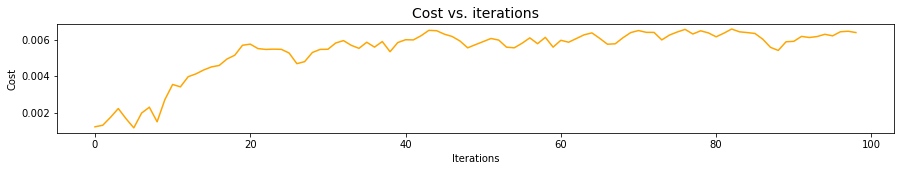

In [417]:
#VARIATION OF COST DURING MCMC

fig,axs = plt.subplots(figsize = (15,2))
axs.plot(RMS_accepted[1:-1], color='orange')
axs.set(xlabel = 'Iterations', ylabel = 'Cost')
axs.set_title('Cost vs. iterations', size = 14)

## Analysis: How to Estimate The Parameters Found With MCMC Algorithm

Now we want to analyse the results of the SA-MCMC algorithm. **First we plot the histograms of each parameters along with a density function automatically fitted by the gaussian.kde package of matplotlib.**

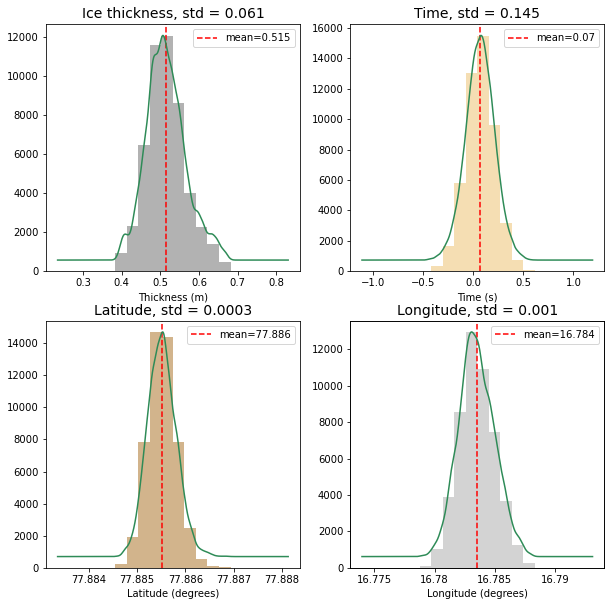

In [401]:
#SHAPE OF PDF

x_lon = np.arange(16.781, 16.79,0.002)
x_lat = np.arange(77.8854,77.8868,0.0004)

fig, axes = plt.subplots(2,2, figsize=(10,10))
axes[0,0].hist(X_MCMC[0,:-1], color='grey', alpha = 0.6)
axes[0,0].set_title('Ice thickness, std = '+str(round(np.std(X_MCMC[0,:it_critic-1]),3)), size=14)
axes[0,0].set(xlabel = 'Thickness (m)')
axes[0,0].axvline(x=np.mean([X_MCMC[0,:-1]]), label='mean='+str(round(np.mean(X_MCMC[0,:-1]),3)),
                  color='red',linestyle='--')
axes[0,0].legend()
ax0 = axes[0,0].twinx()
s = pd.Series(X_MCMC[0,:-1])
s.plot.kde(ax = ax0, color='seagreen')
ax0.axis('off')

axes[1,0].hist(X_MCMC[1,:-1], color='tan')
axes[1,0].set_title('Latitude, std = '+str(round(np.std(X_MCMC[1,:-1]),5)), size=14)
axes[1,0].set(xlabel = 'Latitude (degrees)')
axes[1,0].axvline(x=np.mean([X_MCMC[1,:-1]]), label='mean='+str(round(np.mean(X_MCMC[1,:-1]),3)),
                  color='red',linestyle='--')
axes[1,0].legend()
ax1 = axes[1,0].twinx()
s = pd.Series(X_MCMC[1,:-1])
s.plot.kde(ax = ax1, color='seagreen')
ax1.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax1.axis('off')

axes[0,1].hist(X_MCMC[3,:-1], color='wheat')
axes[0,1].set_title('Time, std = '+str(round(np.std(X_MCMC[3,:-1]),3)), size=14)
axes[0,1].set(xlabel = 'Time (s)')
axes[0,1].axvline(x=np.mean([X_MCMC[3,:-1]]), label='mean='+str(round(np.mean(X_MCMC[3,:-1]),3)),
                  color='red',linestyle='--')
axes[0,1].legend()
ax2 = axes[0,1].twinx()
s = pd.Series(X_MCMC[3,:-1])
s.plot.kde(ax = ax2, color='seagreen')
ax2.axis('off')

axes[1,1].hist(X_MCMC[2,:-1], color='lightgray')
axes[1,1].set_title('Longitude, std = '+str(round(np.std(X_MCMC[2,:-1]),3)), size=14)
axes[1,1].set(xlabel = 'Longitude (degrees)')
axes[1,1].axvline(x=np.mean([X_MCMC[2,:-1]]), label='mean='+str(round(np.mean(X_MCMC[2,:-1]),3)),
                  color='red',linestyle='--')
axes[1,1].legend()
ax3 = axes[1,1].twinx()
s = pd.Series(X_MCMC[2,:-1])
s.plot.kde(ax = ax3, color='seagreen')
ax3.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax3.get_yaxis().set_visible(False)

Then we plot a scatter density for latitude and longitude, in order to better see the most probable location of the icequake.

Text(0, 0.5, 'Latitude (degrees)')

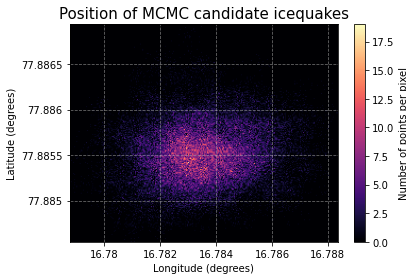

In [408]:
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density=ax.scatter_density(X_MCMC[2,:-1], X_MCMC[1,:-1], cmap='magma')
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.grid(linestyle='--', alpha=0.6)
fig.colorbar(density,label='Number of points per pixel')
plt.title('Position of MCMC candidate icequakes', size=15)
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')

Icequakes are a means of having real data for ice thickness in the Arctic. Ice thickness is an important parameters in climate and sea ice models. Hence we want to have a good convergence of the values of ice thickness in our simulation. We plot 2D density functions for ice thickness vs. time, latitude and longitude.

/home/clameleon/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/clameleon/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/clameleon/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn

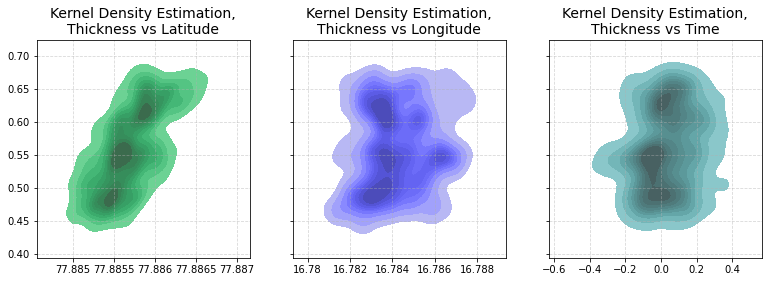

In [400]:
fig, ax = plt.subplots(1,3, sharey= True, figsize=(13,4))

data = pd.Series(X_MCMC[0,:it_critic-1])
data2 = pd.Series(X_MCMC[1,:it_critic-1])
sn.kdeplot(data2,data,color='seagreen',cbar=False, shade=True, ax=ax[0])
ax[0].set_title('Kernel Density Estimation,\nThickness vs Latitude', size=14)
ax[0].grid(linestyle='--', alpha = 0.5)
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%g'))

data2 = pd.Series(X_MCMC[2,:it_critic-1])
sn.kdeplot(data2,data,color='blue',cbar=False, shade=True, ax=ax[1])
ax[1].set_title('Kernel Density Estimation,\nThickness vs Longitude', size=14)
ax[1].grid(linestyle='--', alpha = 0.5)
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%g'))

data2 = pd.Series(X_MCMC[3,:it_critic-1])
sn.kdeplot(data2,data,color='cadetblue',cbar=False, shade=True, ax=ax[2])
ax[2].set_title('Kernel Density Estimation,\nThickness vs Time', size=14)
ax[2].grid(linestyle='--', alpha = 0.5)

Finally we want to compare the original data with a synthetical data based on the best parameters found through SA and MCMC algorithms.

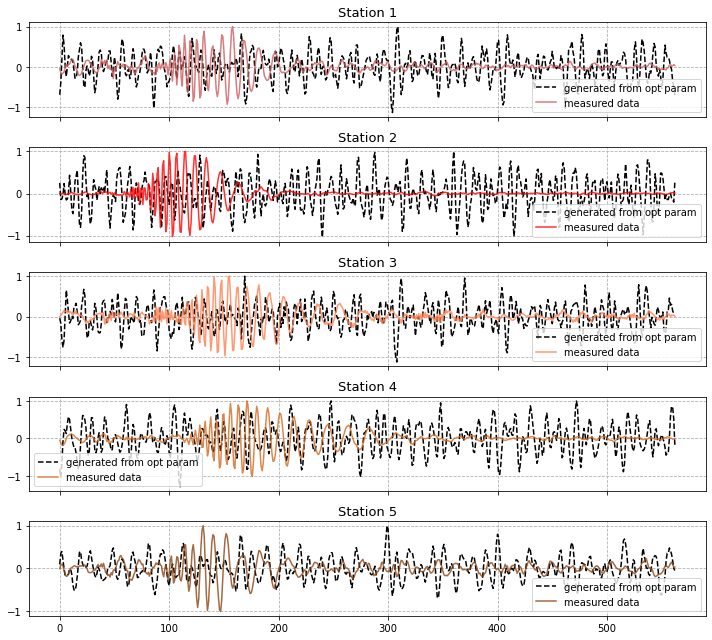

In [419]:
#Compare the signals of the stations and the signals given by the best parameters

data, data_spect, fc,iqk_time = mcmc_iqk.read_data.read_data(path2icqks,stations,sta_cluster,cluster,iqk,fmin,fmax,fe,res,plot=0)

#X_best_guess = mcmc_iqk.candidate.candidate(X_MCMC[:,it_critic-1],delta_param0,MIN_param0,MAX_param0);   

X_MCMC[:,-1] = [np.mean(X_MCMC[0,:-1]),
               np.mean(X_MCMC[1,:-1]),
               np.mean(X_MCMC[2,:-1]),
               np.mean(X_MCMC[3,:-1])]
X_best_guess = mcmc_iqk.candidate.candidate(X_MCMC[:,-1],delta_param0,MIN_param0,MAX_param0);
synthetics = mcmc_iqk.synthetics.synthetics(stations,X_best_guess,t,pulse,cph[np.abs(hhh - X_best_guess[0]).argmin()],plot=0)    
color_ar = ['indianred', 'red', 'coral', 'chocolate', 'saddlebrown']

fig, ax = plt.subplots(5,1,sharex=True, figsize=(10,9))
for i in range(5):
    ax[i].set_title('Station {}'.format(i+1), size= 13)
    ax[i].plot(synthetics[i], label = 'generated from opt param', ls='--', color="black")
    ax[i].plot(data[i], color=color_ar[i], label = 'measured data', alpha = 0.8)
    ax[i].legend()
    ax[i].grid(linestyle='--')
fig.tight_layout()